In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [2]:
from core.cluster_validation import generate_enc_groups
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [1]:
region_id = 69300

In [ ]:
primary = pd.read_parquet(chars_dir + f'primary_chars/primary_chars_{region_id}.parquet')

### Generate context

In [7]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1]) + 1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1] * output_vals))

    istart = 0
    for g in range(ngroups):
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend - 1] == rows[iend]:
            iend += 1

        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):
            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals * c

            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index + 1] = np.nan
                result[g, res_index + 2] = np.nan
                continue

            lower, med, higher = np.nanpercentile(col_vals, (15, 50, 85))
            result[g, res_index] = lower
            result[g, res_index + 1] = med
            result[g, res_index + 2] = higher

        # # go to next group
        istart = iend
    return result

In [8]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(
        np.empty((values.shape[0], values.shape[1] * output_vals)), index=ids
    )

    for source in np.array_split(rows, n_splits):
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step

        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(
            rows_to_pass, columns_to_pass, partial_vals, output_vals
        )

        final_result.iloc[source, :] = partial_res

    return final_result

In [9]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [10]:
## Discard disconnected components and focus on a single component only.
## doesnt make a big difference.

In [11]:
graph.component_labels.value_counts()

component labels
25     176892
24      19069
28       3958
69       3867
99       3368
        ...  
766         1
798         1
799         1
800         1
814         1
Name: count, Length: 815, dtype: int64

cluster only the data from the first component

In [12]:
# data = primary.loc[component_labels]
# data_graph = graph.subgraph(component_labels)
# component_labels = graph.component_labels.copy()
# component_labels = component_labels[component_labels == 0].index.values

cluster only buildings tessellation cells

In [13]:
# data = primary.loc[primary.index >= 0]
# data_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])

In [14]:
data = primary
data_graph = graph

In [15]:
%%time
context = parallel_higher_order_context(
    data, data_graph, k=5, n_splits=10, output_vals=3
)

CPU times: user 3min 33s, sys: 10.6 s, total: 3min 43s
Wall time: 23.4 s


In [16]:
context.columns = np.concatenate(
    [(c + "_lower", c + "_median", c + "_higher") for c in primary.columns]
)

In [17]:
# X = context

In [18]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)
# r = higher.describe(primary['sdbAre'], statistics=['median'])['median']
# from pandas.testing import assert_series_equal
# assert_series_equal(context['sdbAre_median'], r, check_names=False)

# r.duplicated().sum()

### Data preprocessing

In [26]:
import lonboard

In [31]:
plotting = buildings[['id', 'geometry']].reset_index().copy()
plotting['x'] = buildings.representative_point().x
plotting['y'] = buildings.representative_point().y

In [86]:
focus_areas = {
    261795: "karlin",
    238755: "vinohrady",
    270977: "mala strana",
    187419: "holyne",
    187792: "housing estate",
    282165: "stare mesto",
    281093: "nusle",
    149813: "malesice",
}
xs = plotting.loc[list(focus_areas.keys())].representative_point().values.x
ys = plotting.loc[list(focus_areas.keys())].representative_point().values.y


In [35]:
layer = lonboard.PolygonLayer.from_geopandas(
    gdf=plotting, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [87]:
# m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
# m

In [149]:
res = generate_validation_groups(tessellation, include_random_sample=True)

In [150]:
# plotting = tessellation.loc[res.index.values]
# plotting['cluster'] = res.values

In [151]:
# plotting.explore(column='cluster', categorical=True)

In [152]:
tess_groups = generate_validation_groups(tessellation, include_random_sample=True)


def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [153]:
## no spatial lag
X = np.nan_to_num(StandardScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(5.776605369784488)

In [154]:
## no spatial lag
X = np.nan_to_num(RobustScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(6.852735216432622)

In [155]:
## no spatial lag
X = np.nan_to_num(PowerTransformer().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(5.869557282914207)

In [156]:
### only medians

In [157]:
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(3.148022012229912)

In [158]:
X = np.nan_to_num(
    RobustScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(3.3718596143843587)

In [159]:
X = np.nan_to_num(
    PowerTransformer().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")] + 1
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(3.070151741001052)

In [160]:
## clip medians to -10, 10 standard deviations
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(3.1373411824015394)

In [161]:
# all features with lag

In [162]:
# no standardisation
X = np.nan_to_num(context)
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(5.655612072886947)

In [163]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(3.0576375896311356)

In [164]:
X = np.nan_to_num(RobustScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(4.243069449329518)

In [165]:
X = np.nan_to_num(PowerTransformer().fit_transform(context + 1))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


np.float64(2.980889708048656)

In [166]:
## clip to -10, 10 standard deviations
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(3.0256126751963044)

In [167]:
context["sdbAre_lower"].describe()

count    304552.000000
mean         46.920134
std          41.147552
min           1.452315
25%          26.541624
50%          35.902589
75%          57.092934
max        6239.719701
Name: sdbAre_lower, dtype: float64

In [168]:
desc = X.describe()

In [169]:
desc.loc[["25%", "50%", "75%", "max"]]

sdbAre_lower  sdbAre_median  sdbAre_higher  sdbPer_lower  sdbPer_median  \
25%     -0.495254      -0.454014      -0.338362     -0.697457      -0.506656   
50%     -0.267757      -0.196980      -0.217198     -0.275416      -0.144941   
75%      0.247227       0.160286       0.053462      0.491578       0.358987   
max     10.000000      10.000000      10.000000     10.000000      10.000000   

     sdbPer_higher  sdbCoA_lower  sdbCoA_median  sdbCoA_higher  ssbCCo_lower  \
25%      -0.546645           0.0            0.0      -0.040056     -0.697149   
50%      -0.283017           0.0            0.0      -0.040056      0.045021   
75%       0.230531           0.0            0.0      -0.040056      0.712987   
max      10.000000           0.0            0.0      10.000000      9.405304   

     ...  ltkOri_higher  ltkWNB_lower  ltkWNB_median  ltkWNB_higher  \
25%  ...      -0.731404     -0.689498      -0.809142      -0.766553   
50%  ...       0.104194     -0.310216      -0.218093      -0.062373   
75%  ...       0.858204      0.398967       0.635067       0.681451   
max  ...       1.508071     10.000000      10.000000      10.000000   

     likWBB_lower  likWBB_median  likWBB_higher  sdsAre_lower  sdsAre_median  \
25%     -0.684017      -0.732771      -0.671923     -0.204942      -0.311827   
50%     -0.211223      -0.132635      -0.112577     -0.171161      -0.234388   
75%      0.422377       0.442768       0.388890     -0.095654      -0.087055   
max      6.580623       5.218062       4.168613     10.000000      10.000000   

     sdsAre_higher  
25%      -0.441711  
50%      -0.314748  
75%       0.000000  
max      10.000000  

[4 rows x 186 columns]

In [170]:
corrs = context.corr().abs()
upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))

In [171]:
corrs_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
corrs_to_drop

['ssbCCM_lower',
 'ssbCCM_median',
 'linP4W_higher',
 'ldkPer_lower',
 'ldkPer_median',
 'lskCWA_lower',
 'lskCWA_median',
 'lskCWA_higher']

In [172]:
X_no_corr = X.drop(columns=corrs_to_drop)
X_no_corr.shape, check_score(X_no_corr, tess_groups)

((304554, 178), np.float64(3.0182180220335666))

In [173]:
# corrs_to_drop = []
# X_no_corr = X.drop(columns=corrs_to_drop)
# X_no_corr.shape, check_score(X_no_corr, tess_groups)

In [174]:
# X.describe()

In [175]:
desc = X_no_corr.describe()
to_drop = desc.columns[(desc.loc["max"] - desc.loc["min"]) < 0.5].values
to_drop

array(['sdbCoA_lower', 'sdbCoA_median'], dtype=object)

In [176]:
X_different = X_no_corr.drop(columns=to_drop)
X_different.shape, check_score(X_different, tess_groups)

((304554, 176), np.float64(3.018218022033566))

In [177]:
X_no_duplicates = X_different[~X_different.duplicated()]
X_no_duplicates.shape, check_score(X_no_duplicates, tess_groups)

((276071, 176), np.float64(2.9502157231866617))

In [178]:
# tessellation[X_different.duplicated(keep=False)].explore()

In [179]:
# plotting = tessellation.loc[X_different[X_different.duplicated(keep=False)].index.values]
# plotting['sdbAre_lower'] = X_different[X_different.duplicated(keep=False)]['sdbAre_lower']
# plotting = plotting.sort_values('sdbAre_lower')
# plotting['sdbAre_lower']

In [180]:
# layer = PolygonLayer.from_geopandas(
#     gdf=plotting.reset_index()[['geometry', 'index', 'sdbAre_lower']],
#     opacity=.15
# )
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [181]:
# tessellation.loc[graph[250196].index.values].reset_index().explore()

In [182]:
# tessellation.loc[higher[21149].index.values, ].explore()

In [183]:
# tessellation.loc[higher[271717].index.values, ].explore()

In [184]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [185]:
# primary.loc[higher[271717].index.values, 'sdbAre'].median(), primary.loc[higher[271714].index.values, 'sdbAre'].median()

In [186]:
# primary.loc[higher[271717].index.values, 'sdbAre'].describe()

In [187]:
# primary.loc[higher[271714].index.values, 'sdbAre'].describe()

In [188]:
# r = dict([])
# for idx in higher[271717].index.values:
#     r[idx] = (primary.loc[higher[idx].index.values, 'sdbAre'].median())

In [189]:
# dict(sorted(r.items(), key=lambda item: item[1]))

In [190]:
# remove singletons

In [191]:
singletons = graph.unique_ids[graph.cardinalities == 1]

In [192]:
# tessellation.loc[singletons].explore()

In [193]:
X_no_singletons = X_no_duplicates[~X_no_duplicates.index.isin(singletons)]
X_no_singletons.shape, check_score(X_no_singletons, tess_groups)

((275908, 176), np.float64(2.9466198554258547))

In [194]:
# remove empty space

In [195]:
X_buildings = X_no_singletons[X_no_singletons.index >= 0]
X_buildings.shape, check_score(X_buildings, tess_groups)

((270909, 176), np.float64(2.925663551723624))

In [196]:
X_train = X_buildings
X_train.shape, check_score(X_train, tess_groups)

((270909, 176), np.float64(2.925663551723624))

In [197]:
X_train.describe().loc["max"].describe()

count    176.000000
mean       7.454306
std        3.087777
min        0.152549
25%        4.678120
50%        9.981272
75%       10.000000
max       10.000000
Name: max, dtype: float64

### UMAP tests

In [198]:
tess_groups = generate_validation_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=5_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [199]:
def print_umap(embedding_df, title):
    gb_cols = Set3_12.hex_colors

    embedding_groups = embedding_df.groupby("neighbourhood")

    gnames = embedding_df["neighbourhood"].unique()
    genums = np.arange(len(gnames))

    fig, ax = plt.subplots(figsize=(10, 10))

    for genum, gname in zip(genums, gnames, strict=False):
        color = gb_cols[genum]
        label = gname
        es_ = embedding_groups.get_group(gname).values[:, :2]
        ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
    ax.legend()
    ax.set_title(title)
    return ax

In [200]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

15 2 100 0.1 -- 1.7058154463731035
25 2 100 0.1 -- 2.6517426673053364
50 2 100 0.1 -- 2.964653916481618
100 2 100 0.1 -- 1.4787262726200294


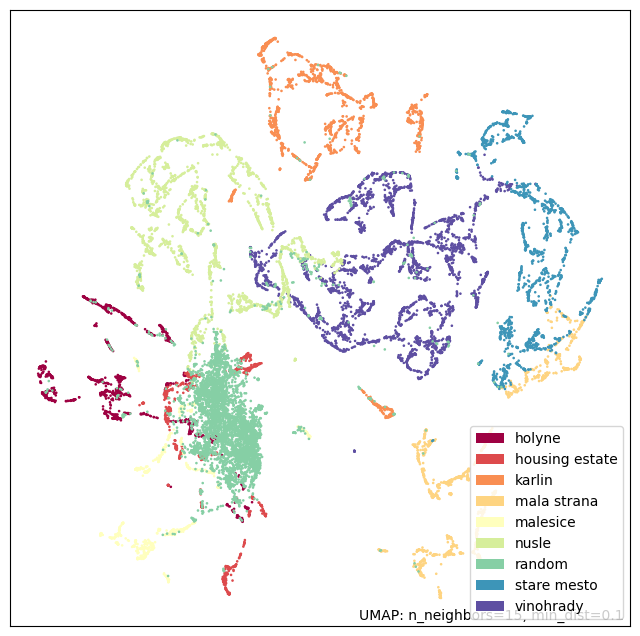

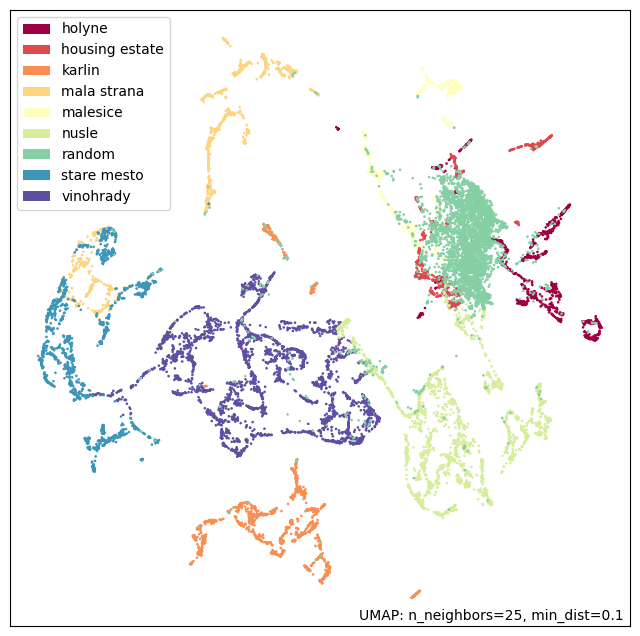

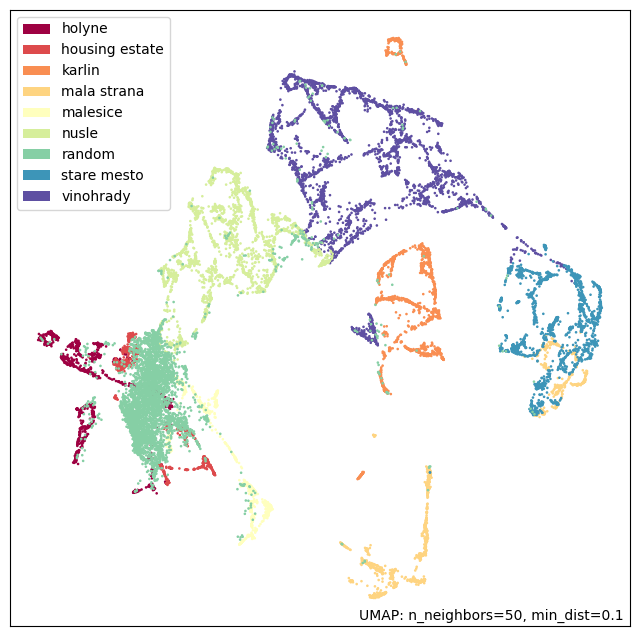

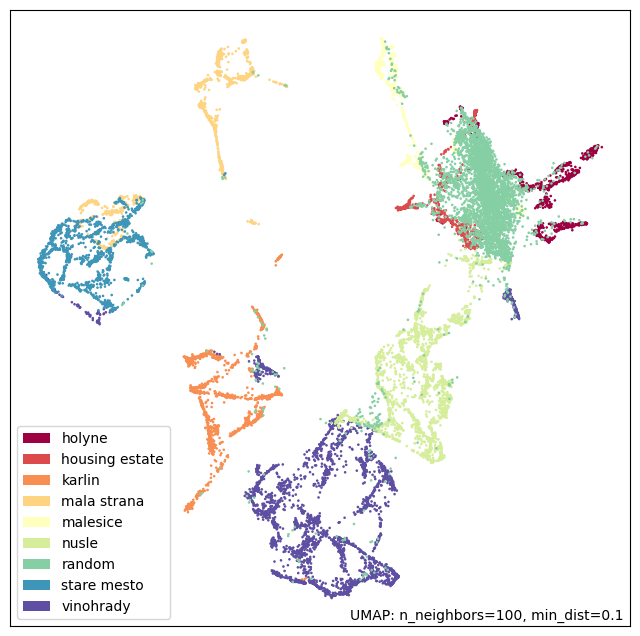

In [201]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.1)

In [46]:
# for n_neighbors in [15, 25, 50, 100]:
#     for n_components in [5, 10, 15]:
#         show_nn(
#             n_neighbors=n_neighbors,
#             n_components=n_components,
#             n_epochs=500,
#             min_dist=0.1,
#         )

15 5 500 0.1 -- 1.4127280161498468
15 10 500 0.1 -- 1.335989354088617
15 15 500 0.1 -- 1.3167221667416629
25 5 500 0.1 -- 1.5001688901799717
25 10 500 0.1 -- 1.3345047808691204
25 15 500 0.1 -- 1.3158634415453951
50 5 500 0.1 -- 1.4639661554549583
50 10 500 0.1 -- 1.4012411750528682
50 15 500 0.1 -- 1.4340224511662558
100 5 500 0.1 -- 1.4749527721376092
100 10 500 0.1 -- 1.4680293072856825
100 15 500 0.1 -- 1.4717436010225011


In [68]:
# for n_neighbors in [30, 100]:
#     for n_components in [5, 10, 15]:
#         for min_dist in [0.0, 0.05, 0.1]:
#             show_nn(
#                 n_neighbors=n_neighbors,
#                 n_components=n_components,
#                 n_epochs=500,
#                 min_dist=min_dist,
#             )

In [202]:
assert not X_train.duplicated().any()

In [203]:
reducer = umap.UMAP(n_neighbors=100, n_components=15, min_dist=0, verbose=True)
embedding = reducer.fit_transform(X_train)

UMAP(min_dist=0, n_components=15, n_neighbors=100, verbose=True)
Thu Jul 18 18:31:14 2024 Construct fuzzy simplicial set
Thu Jul 18 18:31:14 2024 Finding Nearest Neighbors
Thu Jul 18 18:31:14 2024 Building RP forest with 31 trees
Thu Jul 18 18:31:16 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Thu Jul 18 18:32:10 2024 Finished Nearest Neighbor Search
Thu Jul 18 18:32:15 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul 18 18:35:47 2024 Finished embedding


In [204]:
viz_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, verbose=True)
viz_embedding = viz_reducer.fit_transform(X_train)

UMAP(n_neighbors=30, verbose=True)
Thu Jul 18 18:35:47 2024 Construct fuzzy simplicial set
Thu Jul 18 18:35:47 2024 Finding Nearest Neighbors
Thu Jul 18 18:35:47 2024 Building RP forest with 31 trees
Thu Jul 18 18:35:49 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Thu Jul 18 18:35:58 2024 Finished Nearest Neighbor Search
Thu Jul 18 18:35:59 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul 18 18:43:08 2024 Finished embedding


In [205]:
embedding_df = pd.DataFrame(embedding[tess_groups_ilocs, :3], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

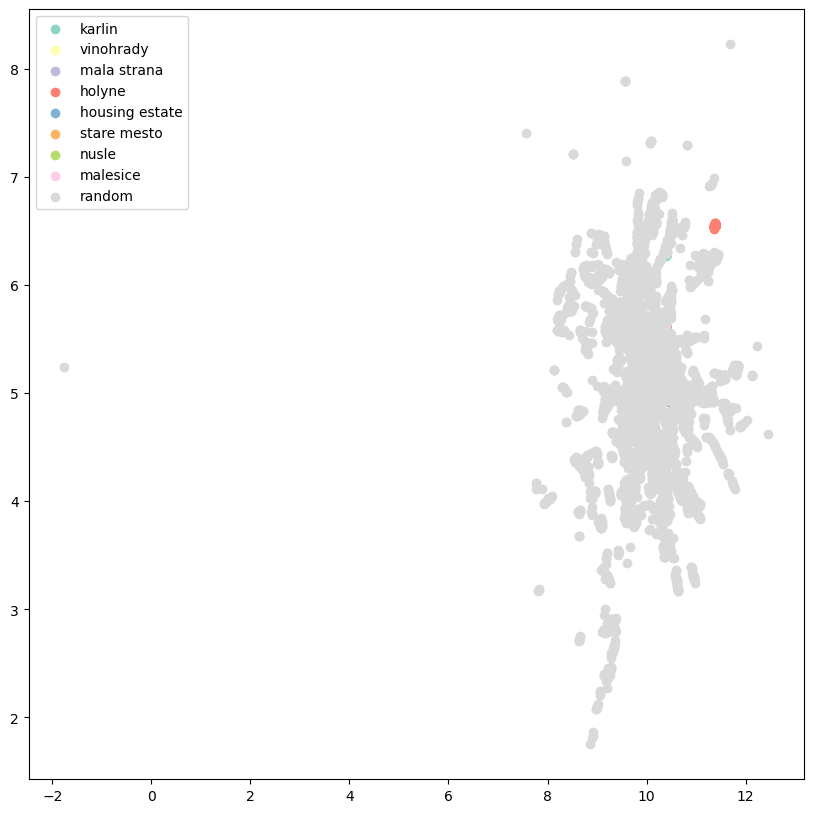

In [206]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")

gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig, ax = plt.subplots(figsize=(10, 10))

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :2]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
ax.legend()

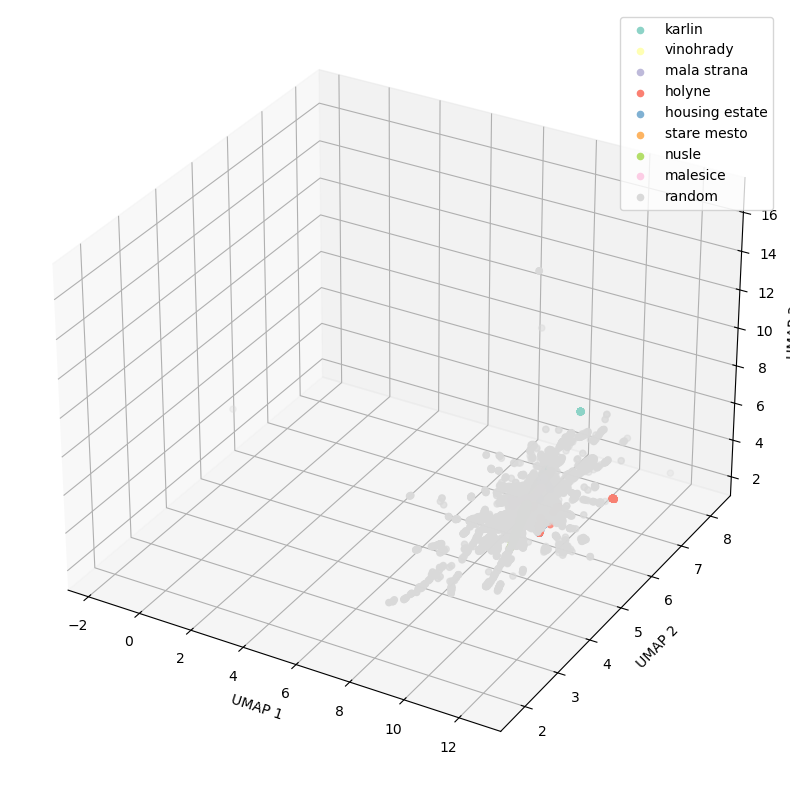

In [207]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()

In [208]:
# ax.view_init(45, 45)
# fig

In [209]:
# ax.view_init(45, 90)
# fig

In [210]:
# ax.view_init(45, 135)
# fig

In [211]:
davies_bouldin_score(embedding[tess_groups_ilocs, :], tess_groups.values)

np.float64(1.7092035811008213)

<Axes: >

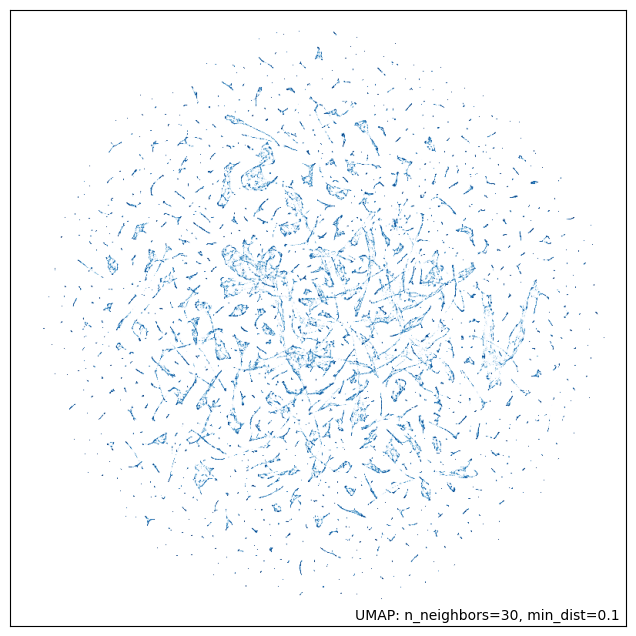

In [212]:
umap.plot.points(viz_reducer)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

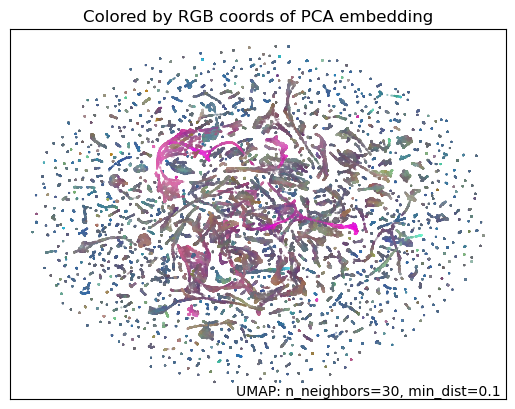

In [81]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="pca")

<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

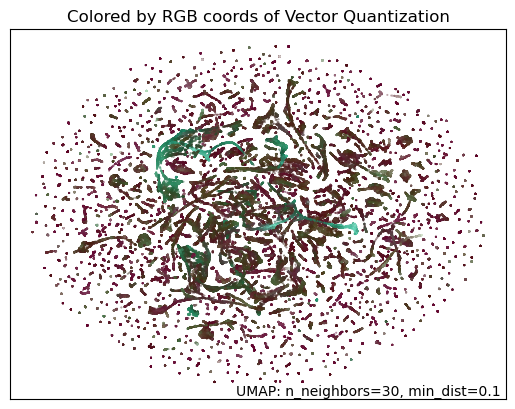

In [82]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="vq")

Mon Jul  1 13:13:28 2024 Worst tree score: 0.91919930
Mon Jul  1 13:13:28 2024 Mean tree score: 0.92128518
Mon Jul  1 13:13:28 2024 Best tree score: 0.92306057
Mon Jul  1 13:13:30 2024 Forward diversification reduced edges from 7761690 to 1122124
Mon Jul  1 13:13:31 2024 Reverse diversification reduced edges from 1122124 to 1122124
Mon Jul  1 13:13:32 2024 Degree pruning reduced edges from 1054788 to 1054788
Mon Jul  1 13:13:32 2024 Resorting data and graph based on tree order
Mon Jul  1 13:13:32 2024 Building and compiling search function


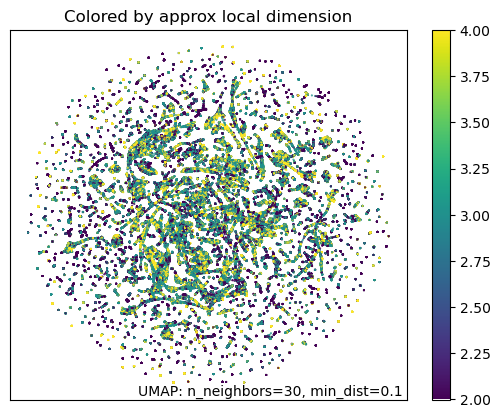

In [83]:
local_dims = umap.plot.diagnostic(viz_reducer, diagnostic_type="local_dim")

In [ ]:
### paint the UMAP embeddings by prague district

In [213]:
czech_admin = (
    gpd.read_file("../../notebooks/data/MAP_CUR_MAP_MESTSKECASTI_P.zip")
    .sort_values("KOD_MC")
    .reset_index(drop=True)
)
admin_id, tess_id = tessellation.loc[X_train.index].sindex.query(
    czech_admin.geometry.to_crs(tessellation.crs), predicate="intersects"
)
import glasbey

gb_cols = glasbey.extend_palette(Set3_12.hex_colors, palette_size=max(admin_id) + 1)
czech_admin["color"] = gb_cols
labels = pd.Series("Bohemia", index=X_train.index)
labels.iloc[tess_id] = czech_admin.iloc[admin_id]["NAZEV_MC"].values
cmap = dict(zip(czech_admin["NAZEV_MC"].values, gb_cols, strict=False))
cmap["Bohemia"] = "#ffffff"

<Axes: >

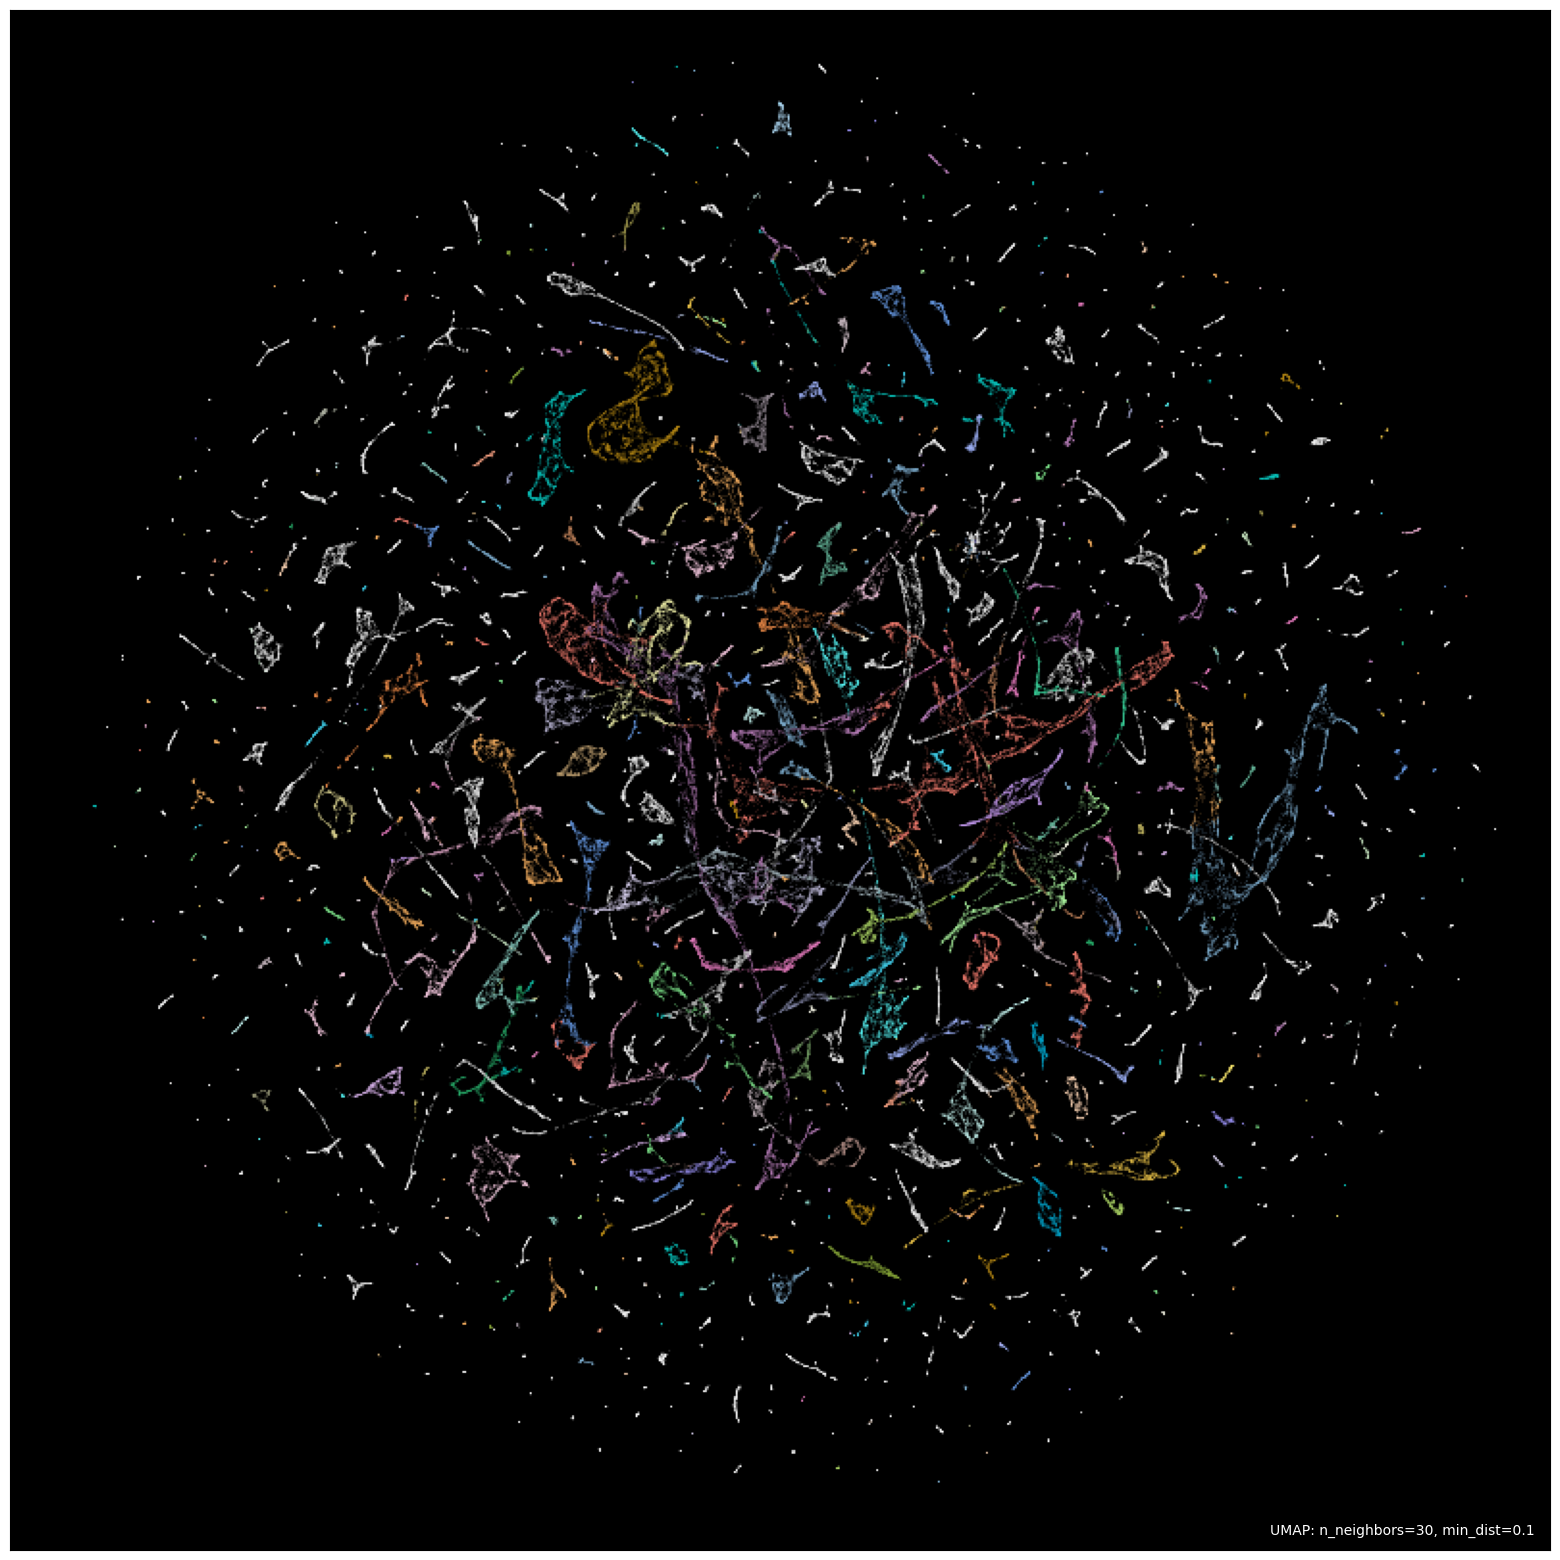

In [214]:
fig, ax = plt.subplots(figsize=(20, 20))
umap.plot.points(
    viz_reducer,
    labels=labels,
    background="black",
    color_key=cmap,
    show_legend=False,
    ax=ax,
)

<Axes: >

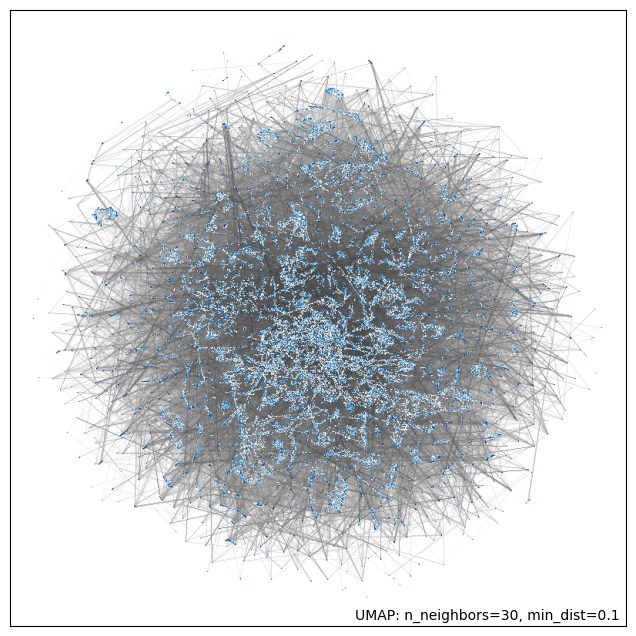

In [94]:
umap.plot.connectivity(viz_reducer, show_points=True)

In [ ]:
np.save(embedding)

In [ ]:
np.save("data/umap_prague_k7_n30_dim15.npy", embedding)

In [ ]:
embedding.shape

In [ ]:
np.load("data/umap_prague_k7_n30_dim15.npy").shape

In [63]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(embedding[tess_groups_ilocs, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label)

In [64]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [65]:
# tessellation.loc[X_different[X_different.duplicated()].index.values].explore()

### PCA tests and comparison

In [215]:
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.decomposition import PCA

In [216]:
%%time
pca_reducer = PCA(n_components=50)
pca_embedding = pca_reducer.fit_transform(X_train)

CPU times: user 2.28 s, sys: 196 ms, total: 2.47 s
Wall time: 165 ms


In [217]:
pca_reducer.explained_variance_ratio_.cumsum()

array([0.24757931, 0.344357  , 0.41222665, 0.46469588, 0.50959872,
       0.5456139 , 0.57879141, 0.60831719, 0.6327565 , 0.65304524,
       0.67251449, 0.68753217, 0.70095627, 0.71298763, 0.72384239,
       0.73425474, 0.74401337, 0.75275633, 0.76086007, 0.76871348,
       0.77609406, 0.78326   , 0.79011714, 0.79664617, 0.80270848,
       0.80862428, 0.81408913, 0.81948867, 0.82474375, 0.8297772 ,
       0.83443563, 0.83891278, 0.84332493, 0.84767756, 0.85186812,
       0.85591617, 0.85976295, 0.86340794, 0.86689156, 0.87023444,
       0.87343152, 0.87653779, 0.87960813, 0.88254814, 0.88537376,
       0.88818303, 0.89083581, 0.89345635, 0.89596062, 0.89844011])

In [218]:
embedding_df = pd.DataFrame(pca_embedding[tess_groups_ilocs], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

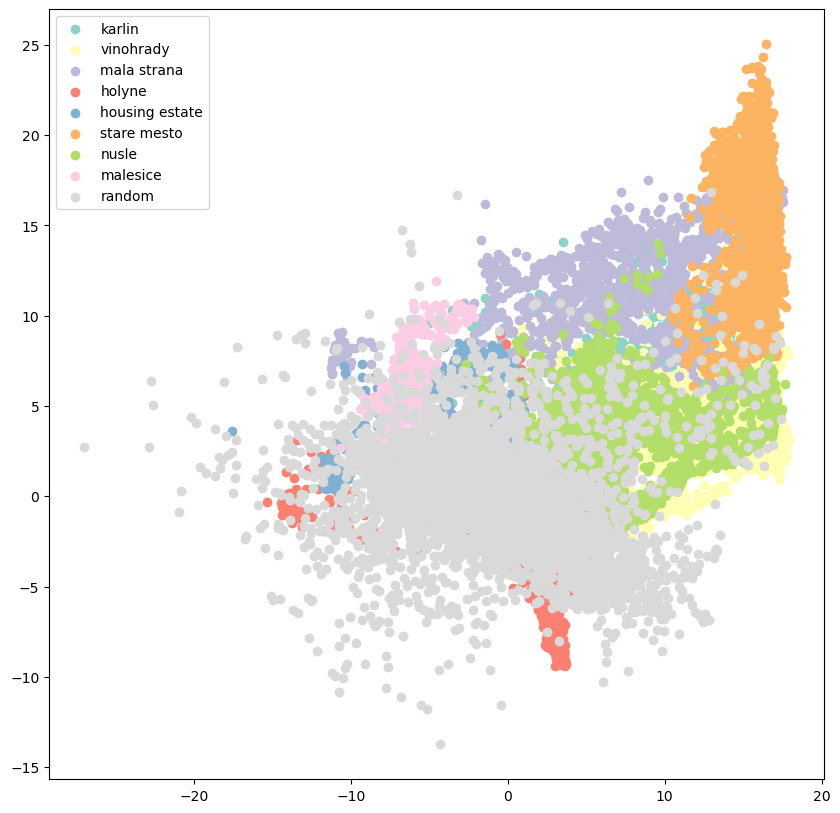

In [219]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :10]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)

ax.legend()

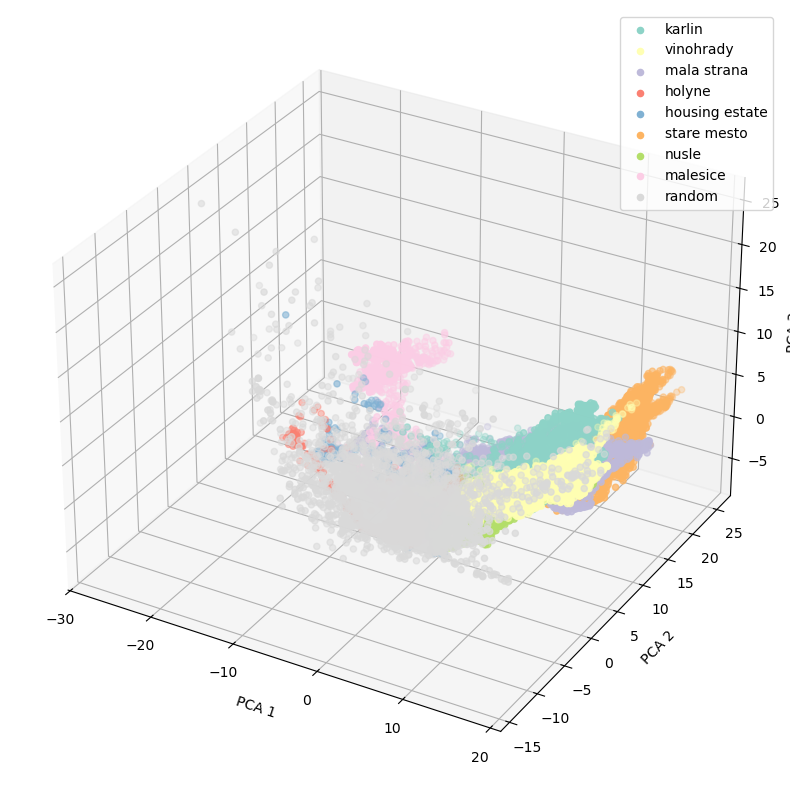

In [220]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

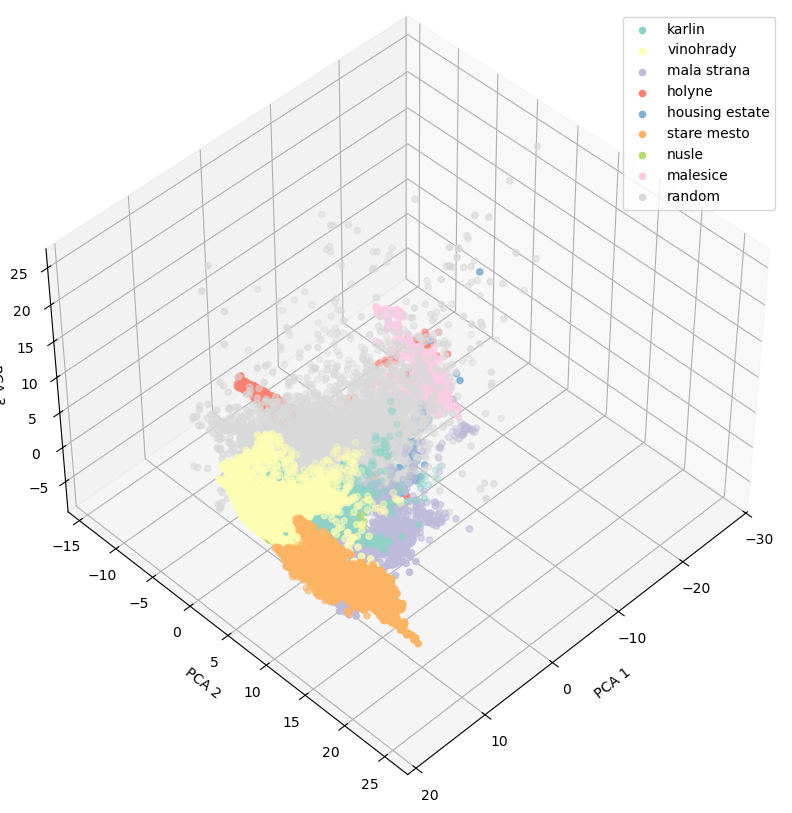

In [221]:
ax.view_init(45, 45)
fig

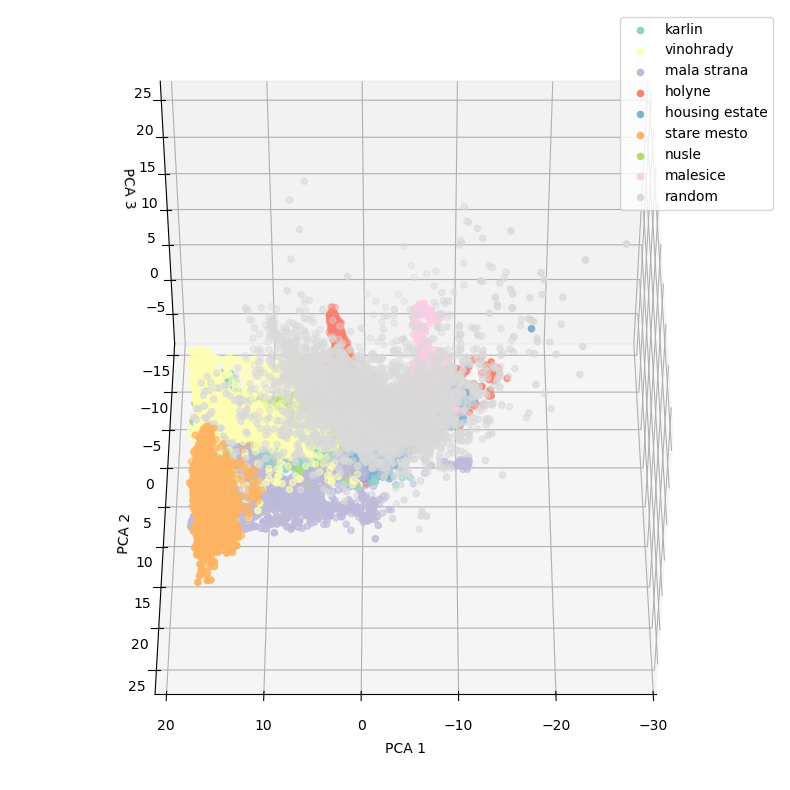

In [222]:
ax.view_init(45, 90)
fig

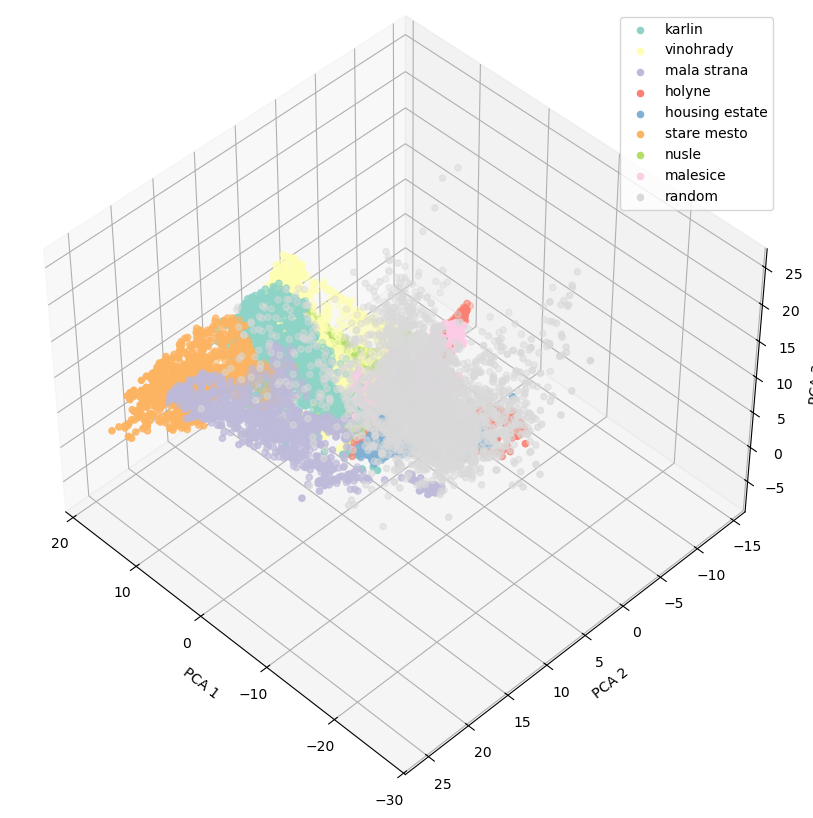

In [223]:
ax.view_init(45, 135)
fig

In [227]:
davies_bouldin_score(pca_embedding[tess_groups_ilocs, :5], tess_groups.values)

np.float64(2.591041143603255)

In [228]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(pca_embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.31958686797923014

In [229]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(pca_embedding[:, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [230]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.5211848128825345

In [231]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [112]:
# np.save('../data/umap.npy', embedding)


In [232]:
# embedding = np.load('../data/umap.npy')

### HDBSCAN

In [233]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [234]:
min_cluster_size = 100

In [235]:
%%time
sklearn_tree = KDTree(embedding)

CPU times: user 253 ms, sys: 7 μs, total: 253 ms
Wall time: 253 ms


In [236]:
%%time
numba_tree = kdtree_to_numba(sklearn_tree)

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 11.2 μs


In [237]:
%%time
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)

CPU times: user 25.9 s, sys: 3.72 ms, total: 25.9 s
Wall time: 2.08 s


In [238]:
sorted_mst = edges[np.argsort(edges.T[2])]

In [239]:
%%time
linkage_tree = mst_to_linkage_tree(sorted_mst)

CPU times: user 9.29 ms, sys: 0 ns, total: 9.29 ms
Wall time: 9.28 ms


In [256]:
condensed_tree = condense_tree(linkage_tree, min_cluster_size=500)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [257]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(tess_groups.values, clusters[tess_groups_ilocs])

0.2521781542992512

In [258]:
np.unique(clusters, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]),
 array([41685,   776,  1621,  2288,  1009,   521,  134

In [259]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [260]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters + 1
plotting = plotting[plotting["label"] > 0]

In [261]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


gb_cols = glasbey.extend_palette(
    Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
)
gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [262]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [264]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [94]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')

In [95]:
with sc:
    display(m)

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

## KMEANS

In [274]:
for k in range(2, 50):
    kmeans_label = (
    KMeans(n_clusters=k)
        .fit(embedding[:, :50])
        .labels_
    )

    print(k, adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs]), davies_bouldin_score(X_train, kmeans_label))

2 0.003237376246120979 3.1278001933361965
3 0.10778497728316966 4.2924817073670445
4 0.13242476270094725 4.568711703499975
5 0.15092070260103865 4.9956507904937135
6 0.16690577751653476 5.752019778085703
7 0.15651727607393923 5.4143091556101535
8 0.15198066884085862 5.165474940430901
9 0.14491347338779645 5.428181168323796
10 0.14793595605605145 5.957218895305586
11 0.15001570654578442 5.186305094643992
12 0.1589008172030111 5.909326556769176
13 0.16439516773450422 5.810593850103282
14 0.1594198945281555 5.5653114286628815
15 0.25273958622617176 5.903480241896473
16 0.13880302107311449 5.765756924394148
17 0.19988416951426727 6.084207717206824
18 0.15565542615466157 6.239446584435763
19 0.1496893838216239 5.850646660251593
20 0.23492072402406725 5.225740242003489
21 0.16966605640630855 5.54684565563795
22 0.15234831646661193 5.961452993047084
23 0.2621611019102862 5.277712846528702
24 0.16696526497385458 5.743287041585013
25 0.1660963562871684 5.8271350761758915
26 0.24995502158522906 

In [275]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = kmeans_label

In [276]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


gb_cols = glasbey.extend_palette(
    Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
)
gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [277]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [279]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m